In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
data = pd.read_csv("train.csv", index_col=0)
# data.head()

In [3]:
# check if df has any na/nan
data.isnull().values.any()

True

/home/nischal/ds/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


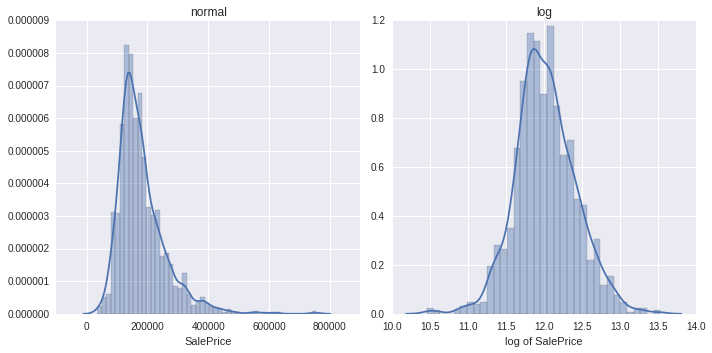

In [4]:
# see how skewed the data is and log values
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
sns.distplot(data.SalePrice)
plt.title("normal")

plt.subplot(1, 2, 2)
sns.distplot(np.log(data.SalePrice))
plt.xlabel("log of SalePrice")
plt.title("log")

plt.tight_layout()

# use log values
data['SalePriceLog'] = np.log(data.SalePrice)

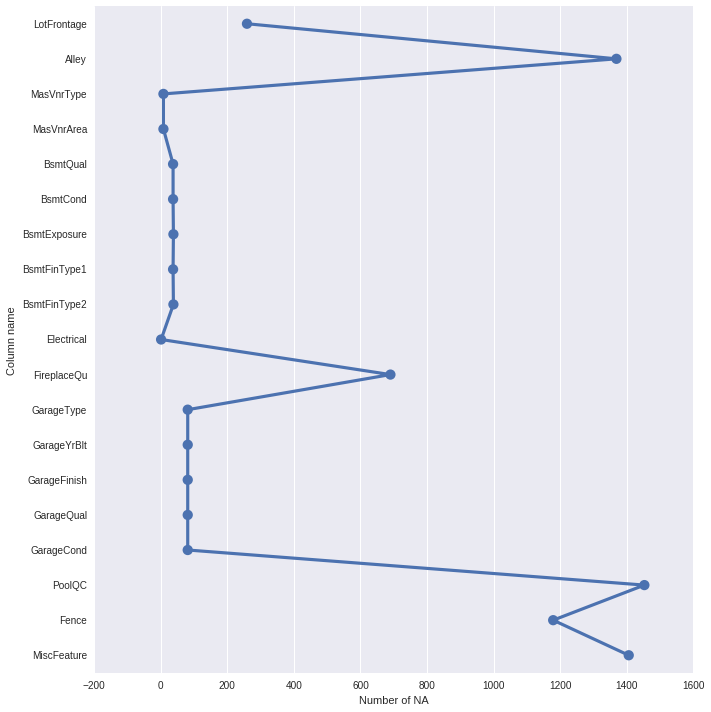

In [5]:
# get number of na/nan values and plot them
sum_na = pd.Series.to_frame(data.isnull().sum())
sum_na.reset_index(inplace=True)
sum_na.columns = [
    'col name',
    'total'
]

# filter na columns 
sum_na = sum_na[sum_na.total != 0]

# plot
ax = sns.factorplot(x="total", y="col name", data=sum_na, size=10, aspect=1)
ax.set(xlabel="Number of NA", ylabel="Column name")

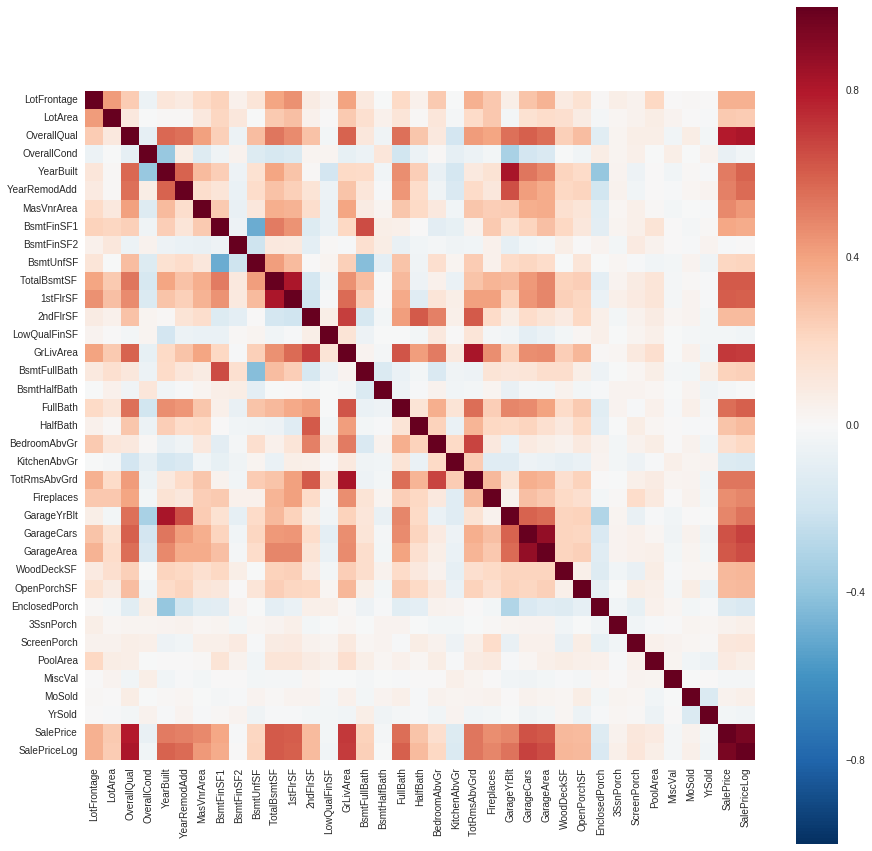

In [6]:
# corr of numeric values with SalePrice
num_only = data.select_dtypes(include=["float64", "int64"])

# remove MSSubClass
num_only = num_only.iloc[:, 1:]

# plot heatmap
corr = num_only.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, square=True)

In [7]:
# list numeric factors that have null
num_null_sum = num_only.isnull().sum()
for nns in num_null_sum:
    if nns > 0:
        print(num_null_sum[num_null_sum == nns].index[0])

LotFrontage
MasVnrArea
GarageYrBlt


In [66]:
# MasVnrArea na -> 0
num_only.MasVnrArea.fillna(0, inplace=True)

# LotFrontage na -> 0
num_only.LotFrontage.fillna(0, inplace=True)

# make GarageYrBlt equal YearBuilt
GarageYrBlt_naIndex = data[data.GarageYrBlt.isnull()].index
for i in GarageYrBlt_naIndex:
    num_only.GarageYrBlt.set_value(i, data.YearBuilt.get_value(i))
    

# no more na numeric values
data.select_dtypes(include=['float64', 'int64']).isnull().any().any()

False

/home/nischal/ds/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/nischal/ds/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1stFlrSF 	 TotalBsmtSF
TotRmsAbvGrd 	 GrLivArea
GarageYrBlt 	 YearBuilt
GarageArea 	 GarageCars


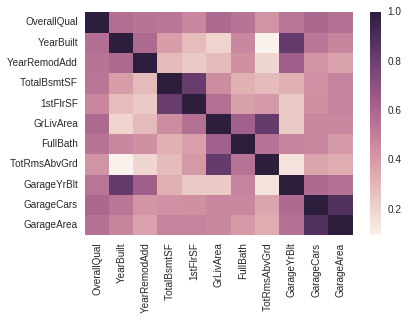

In [11]:
# get matrix for strong corr btw numeric values
st_cor = corr[corr.SalePriceLog > 0.5]
st_cor.drop(st_cor[['SalePriceLog', 'SalePrice']], axis=1, inplace=True)
st_cor = st_cor.transpose()
st_cor = st_cor[corr.SalePriceLog > 0.5]
st_cor.drop(st_cor[['SalePriceLog', 'SalePrice']], axis=1, inplace=True)

# view corr
sns.heatmap(st_cor)

# filter features with high corelation
for index, row in st_cor.iterrows():
    for val in row.values:
        if val == 1.0:
            break
        if val > 0.7:
            print(index, "\t", row[row == val].index[0])

In [97]:
test_data = data[list(st_cor.columns.values)].copy()

In [98]:
# merge cols to simplify
test_data['TotalSF'] = data['1stFlrSF'] + data['TotalBsmtSF']

# delete redundant cols
test_data.drop(['1stFlrSF', 'TotalBsmtSF'], axis=1, inplace=True)
#data.columns

In [99]:
print('corr of sale price with TotRmsAbvGrd', corr.SalePrice[corr.columns.get_loc('TotRmsAbvGrd')])
print('corr of sale price with GrLivArea', corr.SalePrice[corr.columns.get_loc('GrLivArea')])

# drop TotRmsAbvGrd as GrLivArea is more corelated to SalePrice
test_data.drop('TotRmsAbvGrd', axis=1, inplace=True)

corr of sale price with TotRmsAbvGrd 0.533723155582
corr of sale price with GrLivArea 0.708624477613


In [100]:
print('corr of sale price with GarageYrBlt', corr.SalePrice[corr.columns.get_loc('GarageYrBlt')])
print('corr of sale price with YearBuilt', corr.SalePrice[corr.columns.get_loc('YearBuilt')])

# drop GarageYrBlt
test_data.drop('GarageYrBlt', axis=1, inplace=True)

corr of sale price with GarageYrBlt 0.486361677488
corr of sale price with YearBuilt 0.522897332879


In [101]:
print('corr of sale price with GarageArea', corr.SalePrice[corr.columns.get_loc('GarageArea')])
print('corr of sale price with GarageCars', corr.SalePrice[corr.columns.get_loc('GarageCars')])

# drop GarageArea
test_data.drop('GarageArea', axis=1, inplace=True)

corr of sale price with GarageArea 0.623431438918
corr of sale price with GarageCars 0.640409197258


In [103]:
#test_data.drop('SalePriceLog', axis=1, inplace=True)
test_data.head()

,OverallQual,YearBuilt,YearRemodAdd,GrLivArea,FullBath,GarageCars,TotalSF
Id,,,,,,,
1,7,2003,2003,1710,2,2,1712
2,6,1976,1976,1262,2,2,2524
3,7,2001,2002,1786,2,2,1840
4,7,1915,1970,1717,1,3,1717
5,8,2000,2000,2198,2,3,2290


In [40]:
# numeric columns to use for prediction
print('colums to use: ', test_data.columns.values, '\ntotal: ', test_data.columns.size)

colums to use:  ['OverallQual' 'YearBuilt' 'YearRemodAdd' 'GrLivArea' 'FullBath'
 'GarageCars' 'TotalSF'] 
total:  7


In [48]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

In [52]:
# cross val with selected columns
scorer = make_scorer(mean_squared_error, greater_is_better=False)
clf = RandomForestRegressor(n_jobs=-1, n_estimators=500)
score = np.sqrt(-cross_val_score(estimator=clf, X=test_data, y=data.SalePriceLog, cv=15, scoring=scorer, n_jobs=-1))

In [76]:
print('for cv with selected columns: \nmin score: ', score.min(), '\nmax score:', score.max(), '\nmean: ', score.mean())

for cv with selected columns: 
min score:  0.133800569728 
max score: 0.195189456981 
mean:  0.160271872279


In [ ]:
# cross val with all numeric col (except GarageYrBlt)
num_only.drop('SalePrice', axis=1, inplace=True)
num_only.drop('SalePriceLog', axis=1, inplace=True)
num_only.drop('GarageYrBlt', axis=1, inplace=True)

In [64]:
num_score = np.sqrt(-cross_val_score(estimator=clf, X=num_only, y=data.SalePriceLog, cv=15, scoring=scorer, n_jobs=-1))

In [77]:
print('for cv with all columns: \nmin score: ', num_score.min(), '\nmax score:', num_score.max(), '\nmean: ', num_score.mean())

for cv with all columns: 
min score:  0.110659159613 
max score: 0.184044787585 
mean:  0.143472766839


In [81]:
# using num_only columns
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_data, data.SalePriceLog)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

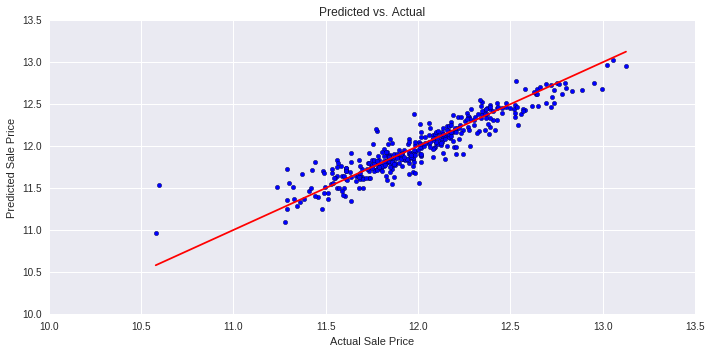

In [83]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.tight_layout()

In [127]:
new_test_data = pd.read_csv("test.csv", index_col=0)
new_test_data = new_test_data.select_dtypes(include=['float64', 'int64']).iloc[:, 1:]

In [128]:
new_test_data.TotalBsmtSF.fillna(0, inplace=True)
new_test_data.GarageCars.fillna(0, inplace=True)
new_test_data['TotalSF'] = new_test_data['1stFlrSF'] + new_test_data['TotalBsmtSF']
new_test_data = new_test_data[list(test_data.columns.values)].copy()

In [130]:
y_test_pred = clf.predict(new_test_data)
test_df = pd.DataFrame(index=new_test_data.index.copy())
y_test_pred = np.exp(y_test_pred)
test_df['SalePrice'] = y_test_pred

In [146]:
test_df.to_csv("sub.csv")